# import

In [1]:
import sys
import os
import import_ipynb
import points
import time
import math
import numpy as np
import pickle as cPickle
import scipy.cluster.hierarchy as H
import scipy.spatial.distance as Dist
import matplotlib.pyplot as plt

importing Jupyter notebook from points.ipynb


In [2]:
sys.setrecursionlimit(10000000)

dir = 'C:\\Users\\IBK\\Desktop\\\DataMining\\Geolife Trajectories 1.3\\Data\\' # .plt 데이터 위치

# -------------------------------------------------------------------------------------------------------

# Point Class
- Point와 StayPoint 클래스와 관련 메소드들이 있다.
    - text 데이터 -> Point 객체
    - point 끼리의 거리 구하기
    - 각 plt 파일에서 staypoint들을 구해, 전체 plt 파일의 staypoint들을 구하기 (한 유저의 staypoint구하기)

## Point 객체

In [3]:
class Point:
    def __init__(self): # 멤버변수 초기화
        self.latitude = 0.0
        self.longitude = 0.0
        self.time = 0.0

## StayPoint 객체

In [4]:
class StayPoint:
    def __init__(self):
        self.latitude = 0.0
        self.longitude = 0.0
        self.arrivalTime = 0.0
        self.leaveTime = 0.0

## Staypoint 좌표 구하는 함수 

In [5]:
def meanCoord(points):
    latitudes = [0] * len(points)
    longitudes = [0] * len(points)
    for i in range(0, len(points)):
        latitudes[i] = points[i].latitude
        longitudes[i] = points[i].longitude

    return np.mean(np.array(latitudes)), np.mean(np.array(longitudes))

## point 데이터(text)를 Point객체로 만들어 넣어주는 함수(Param: point 데이터 값).

In [6]:
def getPointViaString(line):
    point = Point() #객체 생성

    line_element = line.split(',') # text를 각 요소 text로 나눠줌
    #그리고 각각을 객체 멤버변수에 넣어준다.
    point.latitude = float(line_element[0])
    point.longitude = float(line_element[1])
    point.time = time.mktime(time.strptime(line_element[5] + line_element[6], '%Y-%m-%d%H:%M:%S'))

    return point

## point의 거리를 구하는 함수 (Param: point1, point2)

In [7]:
def gpsDistance(pi, pj):
    radLat1 = math.radians(pi.latitude)
    radLat2 = math.radians(pj.latitude)
    a = radLat1 - radLat2;
    b = math.radians(pi.longitude) - math.radians(pj.longitude)

    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2), 2) +
                                math.cos(radLat1) * math.cos(radLat2) * math.pow(math.sin(b/2), 2)))
    EARTH_RADIUS = 6378137
    s *= EARTH_RADIUS
    # s = (s * 10000) / 10000
    return s

## StayPoint 를 추출하는 함수 ( Param: point들의 trajectory데이터, 거리,시간임계값)

In [8]:
def getStayPoints(userTrajectories, DisThreh, TimeThreh):
    listStayPoints = [] # 한 유저의 전체 PLT 파일에서 각각 추출한 Staypoint 들의 배열 변수


    for traj in userTrajectories: # 한 유저의 전체 trajectory 데이터 안의 parsing된 points trajectory 데이터들을 반복
        #traj : 여러개의 point set 들 = 각 plt파일 데이터
        iteOuter = 0 # 기준이 될 point 카운트 변수
        aPointList = [] # 
        while iteOuter < len(traj.trajectory): # plt파일에 있는 각 point 개수만큼 반복
            # print iteOuter
            iteInner = iteOuter + 1 # 다른 point 들과 비교하기위한 카운트 변수
            while iteInner < len(traj.trajectory): # 기준 point 말고 다른 point들을 비교하기 위해 반복
                if gpsDistance(traj.trajectory[iteOuter], traj.trajectory[iteInner]) < DisThreh: # 기준(iterOuter 번째) point 와 비교(iterInner번째) point 의 거리가 임계값을 넘지않고, 
                    if traj.trajectory[iteInner].time - traj.trajectory[iteOuter].time > TimeThreh: # 두개의 포인트 사이의 시간이 시간 임계값을 넘어가면,
                        stayPoint = StayPoint() #기준점과 비교점사이의 point의 정보로 stayPoint 객체를 생성
                        stayPoint.latitude, stayPoint.longitude = meanCoord(traj.trajectory[iteOuter:iteInner+1]) #staypoint 좌표구하는 함수
                        stayPoint.arrivalTime = traj.trajectory[iteOuter].time #staypoint 시작 시간
                        stayPoint.leaveTime = traj.trajectory[iteInner].time #staypoint 끝 시간
                        aPointList.append(stayPoint) # aPointList 배열에 하나의 plt파일 데이터안에서 생긴 stayPoint들을 넣어준다.
                        #print(stayPoint.arrivalTime ,"//",stayPoint.leaveTime)
                    iteOuter = iteInner
                    break
                iteInner += 1
            iteOuter = iteInner
#         print(aPointList) #Staypoint 가 없는 plt 파일은 빈 요소가 들어가 있다. 빈상태로 [] aPointList 배열에 추가된다. 
        listStayPoints.append(aPointList) # 각 plt파일 데이터들에서 만들어진 aPointList 배열(하나의 plt파일에서 만들어진 stayPoint들) 을 넣어준다.
#         print(len(listStayPoints)) # 각 plt의 개수가 나와야한다. 각 plt마다 staypoint들을 구했으므로
        # listStayPoints = [listStayPoints, aPointList]

    return listStayPoints

# -------------------------------------------------------------------------------------------------------

#  Trajectory Class
- Trajectory 객체를 생성

In [9]:
class UserTrajectory:
    def __init__(self, uid, trajectory):
        self.uid = uid
        self.trajectory = trajectory

## PLT 파일을 처리하기 쉬운 형태로 parsing 하는 함수(Param: plt 파일 경로)
- plt 파일을 열고 데이터를 읽고 allTheText 변수에 다음 밑의 예시 형식으로 받아온다.

In [10]:
def parsePltFile(fileDir):
    
    file = open(fileDir) #plt 파일 열고 변수 저장
    pointSet = [] # plt파일에 들어있는 point들이 들어갈 배열
    try:
        allTheText = file.read().split('\n')[6:-1] #각 point의 정보가 배열로 들어간다.
        '''
        ['40.008304,116.319876,0,492,39745.0902662037,2008-10-24,02:09:59', 
        '40.008413,116.319962,0,491,39745.0903240741,2008-10-24,02:10:04']
        이런식으로 데이터 뽑힘.
        '''
        
        #print(allTheText)
    finally:
        file.close()
    for iterText in range(0, len(allTheText)): # allTheText 배열의 요소길이만큼,
        pointSet.append(getPointViaString(allTheText[iterText])) # poinSet배열에 배열 요소의 데이터를 추출해 각 Point객체로 만들어 넣어준다.
    #print(pointSet)
    #print("plt file parsing success!")    
        
    return pointSet

## GPS Log parsing 해서 Trajectory 데이터로 변환 함수 (Param : 해당 유저번호, 해당 유저 데이터 경로, 거리, 시간임계 값)

In [11]:
def getTrajectory(uid, userDir, DisThreh, TimeThreh):
    Trajectory = [] # 변환된 Trajectory 데이터를 넣을 배열 변수
    pointSet = [] #
    
    # global Trajectory , userDir 안의 Trajectory 폴더가 있고, 그 안의 해당 유저의 모든 날짜의 대한 데이터들을 접근
    userDir += "\\Trajectory\\" 
    fileDirs = os.listdir(userDir)
        
    lastFileLastLine = None
    dir = 0 # Trajectroy 폴더안의 파일의 인덱스 
    
    if fileDirs != [] and len(fileDirs) > 0: #폴더 안에 데이터가 있으면,
#         print(uid," 번 유저의 위치 데이터 폴더 접근 성공")
#         print(len(fileDirs))
        while dir < len(fileDirs): #데이터 파일 개수만큼 반복
#             print(uid,"번 유저의",dir,"번 째 plt파일 접근 성공")
#             print(dir)
            pointSet = parsePltFile(userDir + fileDirs[dir]) #Plt파일을 처리하기 쉬운 형태로 parsing 하는 함수
            dir +=1
# 이걸 왜해주는거지???            
#             #마지막 plt 파일도 처리하기 쉬운 형태로 parsing 하기
#             addFile = 1
#             while True:  #and dir + addFile < len(fileDirs):
#                 if dir + addFile >= len(fileDirs):
#                     dir = dir + addFile
#                     break
#                 tmpFile = open(userDir + fileDirs[dir + addFile])
# #                 print(tmpFile)
#                 tmpPoint = getPointViaString(tmpFile.read().split('\n')[6])
#                 tmpFile.close()
#                 if gpsDistance(pointSet[-1], tmpPoint) > DisThreh and tmpPoint.time - pointSet[
#                     -1].time > TimeThreh:
#                     dir = dir + addFile
#                     break
#                 pointSet += parsePltFile(userDir + fileDirs[dir + addFile])
#                 # pointSet.append(parsePltFile(userDir + fileDirs[dir + addFile]))
#                 addFile += 1
            
            Trajectory.append(UserTrajectory(uid, pointSet)) # 해당 유저의 parsing된 pointSet을 userid 를 참조해서 Trajectory 배열에 넣는다.
#         print(pointSet)    
            
    return Trajectory # 각 유저의 Trajectory 데이터 

## Location History Class
- Location History 객체 생성

In [12]:
class UserLocationHistory:
    def __init__(self, uid, locationhistory):
        self.uid = uid
        self.locationhistory = locationhistory

## Personal Location History 얻는 함수 ( Param : 유저번호, StayPoint들의 배열)
 - 각 유저의 staypoint들을 순서대로 배열로 이어준다.

In [13]:
def PersonalLocHis(uid, StayPointList): #staypoint들을 이은뒤 LocationHistory 객체로 만든다.
    
    PersonalUserLocationHistory = []
    
    for staypoints in StayPointList: #StayPointList = 한명의 유저의 StayPointList 배열
        if staypoints != [] and len(staypoints) > 0: #staypoint들이 있는 plt파일들만 
#             print("각 plt의 staypoints 개수:", len(staypoints))
            for i in range(0, len(staypoints)): # 각 plt 파일의 staypoints 들을
                PersonalUserLocationHistory.append(staypoints[i]) #개인의 Location History의 배열에 넣어준다.
#     print(PersonalUserLocationHistory)
    personallocationhistory = UserLocationHistory(uid, PersonalUserLocationHistory)
        
    return personallocationhistory #각 유저이 location history
    
    

## Location History 얻는 함수 ( 매개변수 : 데이터 경로, 거리, 시간 임계값)
 - 각 유저의 GPS Log 를 Trajectory 로 파싱한다.
 - 파싱한 Trajectory 에서 Staypoint 를 추출한다.
 - 각 유저의 StayPoint 를 하나의 SP 배열에 모두 넣는다. SP배열의 크기는 유저의 수
 - 각 유저의 StayPoint 들을 이어서 Location History를 만든다.
 - 개인의 Location History 배열들을 전체 TotalLocation History로 만들어 하나의 객체로 만든다.

In [14]:
def getLocationHistory(DataDir, DisThreh, TimeThreh):
    fileDirs = os.listdir(DataDir) #DataDir 폴더안의 폴더 목록
    TotalLocationHistory = [] #Location History가 담길 배열
    SP = [] # 모든 유저들의 staypoints 배열의 배열
    if fileDirs != [] and len(fileDirs) > 0:
        print("해당 폴더안의 읽을 폴더들어 있습니다.")
        for uid in range(0, len(fileDirs)): #uid: fileDirs목록의 폴더인덱스 = 유저 인덱스  
            print (DataDir + fileDirs[uid] , "읽기")
            #Traj : 각각 유저의 전체 Trajectory 데이터
            Traj = getTrajectory(uid, DataDir + fileDirs[uid], DisThreh, TimeThreh) # GPS Log parsing 해서 Trajectory 데이터로 변환 함수
            print("GPS LOG -> Trajectory success!")
            S = getStayPoints(Traj, DisThreh, TimeThreh) # 각 plt파일의 Trajectory 로 부터 Staypoint들을 추출해 Stayppoints 배열을 만든다. staypoint가 없는 plt파일의 staypoints는 빈칸이다.
            print("Trajectory -> Staypoints success!")
            #지금 까지는 각 유저들의 정보를 구했다. 구한 정보를 합쳐 준다.
            SP.append(S) # 각 유저의 staypoint배열을 합쳐준다.
            print(uid , "번째 유저의 staypoint 합치기 success!")
            #print(S)
            # 각 유저의 staypoint배열(중복되는 staypoint가 있을수도 있음)을 시간대로 긴 하나의 staypoint history로 만들어야한다.
            LocationHistory = PersonalLocHis(uid, S)  #각 유저의 locationhistory 데이터를 모은 객체를 생성
            TotalLocationHistory.append(LocationHistory) # 각 lcation history 객체를 전체 locationhistory 배열에 합쳐준다.
            print(TotalLocationHistory)
            print(uid , "번째 유저의 location history 합치기 success!")
             
#         print(SP) #SP 배열의 크기는 유저의 수이다. 유저 수만큼 유저들의 staypoint배열이 생기기 떄문
            
            
          
    return TotalLocationHistory , SP

# -------------------------------------------------------------------------------------------------------

# TBHG Class 

## TreeNode 객체
### - TreeNode 객체인 기준 노드의 멤버변수인 SplitPoint를 초기화해주는 함수(param: 나누는 point 번호) 
    - 완전 처음에는 -1 부터 시작

In [15]:
class TreeNode(object): 
    def __init__(self, points, start, end, parentNode): # RPoints(order순서의 staypoint좌표), 0, len(RPoints), None(부모노드)
        self.points = points 
        self.start = start
        self.end = end
        self.parentNode = parentNode
        self.children = []
        self.splitpoint = -1
        self.neighbor = []
    #def __str__(self):
    #    return "start: %d, end %d, split: %d" % (self.start, self.end, self.splitpoint)
    
    def assignSplitPoint(self, splitpoint):
        self.splitpoint = splitpoint
        
    def addChild(self, child):
        self.children.append(child)

## OPTICS 알고리즘 함수 (Param: 좌표 배열, 군집 개수)

In [16]:
def optics(x, k, distMethod='euclidean'):
#     x.shape = (x의 개수, x의 크기 ) , len(x.shape) = x의 크기 . 거의 2(위도,경도)
    if len(x.shape) > 1:
        m, n = x.shape # m  = x의개수, n = x의 크기 // 대부분 x으 크기가 2므로 , 이 조건이 적용됨.
        
    else:
        m = x.shape[0]
        n = 1
    
    try:
        D = Dist.squareform(Dist.pdist(x, distMethod))
        distOK = True
    except:
        print("squareform or pdist error")
        distOK = False

    CD = np.zeros(m) # core distance : m 개수만큼 0 으로 이루어진 배열 만들기.
    RD = np.ones(m) * 1E10 # reachable distance : m개수만큼 1E10으로 이루어진 배열 만들기
    
    for i in range(m):
        #again you can use the euclid function if you don't want hcluster
#        d = euclid(x[i],x)
#        d.sort()
#        CD[i] = d[k]

        tempInd = D[i].argsort()
        tempD = D[i][tempInd]
#        tempD.sort() #we don't use this function as it changes the reference
        CD[i] = tempD[k]#**2


    order = []
    seeds = np.arange(m, dtype = np.int)

    ind = 0
    
    while len(seeds) != 1:
#    for seed in seeds:
        ob = seeds[ind]
        seedInd = np.where(seeds != ob)
        seeds = seeds[seedInd]

        order.append(ob)
        tempX = np.ones(len(seeds))*CD[ob]
        tempD = D[ob][seeds]#[seeds]
        #you can use this function if you don't want to use hcluster
        #tempD = euclid(x[ob],x[seeds])

        temp = np.column_stack((tempX, tempD))
        mm = np.max(temp, axis = 1)
        ii = np.where(RD[seeds]>mm)[0]
        RD[seeds[ii]] = mm[ii]
        ind = np.argmin(RD[seeds])
        #print(len(seeds))


    order.append(seeds[0])
    RD[0] = 0 #we set this point to 0 as it does not get overwritten
    print("OPTICS 알고리즘 적용 success!")
    return RD, CD, order


## Local Maxima 가 맞는지 확인하는 함수

In [17]:
def isLocalMaxima(index, RPlot, RPoints, nghsize):
    # 0 = point at index is not local maxima
    # 1 = point at index is local maxima

    for i in range(1, nghsize + 1):
        # process objects to the right of index
        if index + i < len(RPlot):
            if (RPlot[index] < RPlot[index + i]):
                return 0

        # process objects to the left of index
        if index - i >= 0:
            if (RPlot[index] < RPlot[index - i]):
                return 0

    return 1

## Local Maxima 가 되는 Point를 찾는함수 (param : order순서, order순서의 좌표값, 이웃 point 크기)
- 찾는 이유 : reachability distance 가 높은 부분을 찾기 위해서
- Local Maxima Point의 정렬 순서인 숫자 배열을 리턴한다. 그 숫자를 가지고 RPoints에서 좌표값을 해당 좌표값을 찾거나, RPlot에서 RD를 참조할수 있다.

In [18]:
def findLocalMaxima(RPlot, RPoints, nghsize):
    localMaximaPoints = {} # LocalMaximum 이 되는 포인터 {} 딕셔너리는 선언하고 초기화. 즉, 그 안의 속성에 접근하기 위해 사용

    # 1st and last points on Reachability Plot are not taken as local maxima points
    for i in range(1, len(RPoints) - 1):
        # if the point is a local maxima on the reachability plot with
        # regard to nghsize, insert it into priority queue and maxima list
        if RPlot[i] > RPlot[i - 1] and RPlot[i] >= RPlot[i + 1] and isLocalMaxima(i, RPlot, RPoints, nghsize) == 1:
            localMaximaPoints[i] = RPlot[i]

    return sorted(localMaximaPoints, key=localMaximaPoints.__getitem__, reverse=True)

## order 순서의 staypoint 좌표배열 정보가 들어간 rootNode로부터 계층적 Tree 만드는 함수(param: rootNode, 부모노드(초기에는 없음), localMaximaPoints, order, order순서의 좌표, min_cluster_size)

In [19]:
def clusterTree(node, parentNode, localMaximaPoints, RPlot, RPoints, min_cluster_size):
    # node is a node or the root of the tree in the first call
    # parentNode is parent node of N or None if node is root of the tree
    # localMaximaPoints is list of local maxima points sorted in descending order of reachability 
    if len(localMaximaPoints) == 0: #localMaima 가 없는건, clsuter될 노드가 없는 거이므로 rootnode가 leaf 이게 되겠지.
        return  # parentNode is a leaf
    
    # take largest local maximum as possible separation between clusters 일단 맨처음으로 가장 큰 lcalMaximaPoints 찾아서 clustering기준으로 한다.
    s = localMaximaPoints[0]
    #print(RPlot[s] , RPoints[s]) #해당 RD 와  좌표값
    
    node.assignSplitPoint(s) #  가장 RD가 높은 point(= s 숫자)를 기준 TreeNode 객체 node의 멤버변수인 SplitPoint(숫자)로 초기화 해준다.
#     print(node.points)
#     print(node.start)
#     print(node.end)
#     print(node.parentNode)
#     print(node.splitpoint)
    localMaximaPoints = localMaximaPoints[1:] # 초기화한 SplitPoint 는 제외한다.
    #print(localMaximaPoints)
  
    # create two new nodes and add to list of nodes 
    # Splitpoint (s)를 기준으로 나눠지는 두개의 TreeNode 객체 생성 (s는 두개의 노드에 포함되지 않는다.)
    Node1 = TreeNode(RPoints[node.start:s], node.start, s, node) #s번째 point는 포함하지 않는다.
    Node2 = TreeNode(RPoints[s + 1:node.end], s + 1, node.end, node) #node.end번째 point는 포함하지않는다.
#     print(len(Node1.points), Node1.start, Node1.end)
#     print()
#     print(len(Node2.points), Node2.start, Node2.end) # ex) start=375 ,end=389 면 14개의 값이 들어있다. 15개 아님x
    
    #위의 2개의 TreeNode 객체 point범위안의 localMaximapoint들을 다시 정렬해야한다.
    LocalMax1 = [] 
    LocalMax2 = []

    for i in localMaximaPoints:
        if i < s:
            LocalMax1.append(i)
        if i > s:
            LocalMax2.append(i)
#     print(LocalMax1)
#     print(LocalMax2)
    
    Nodelist = [] #Nodelist에 나눠진 2개의 TreeNode객체와 그 범위안의 LocalMaximapoint들을 넣어준다.
    Nodelist.append((Node1, LocalMax1))
    Nodelist.append((Node2, LocalMax2))
    
    # set a lower threshold on how small a significant maxima can be
    significantMin = .003
    #print(RPlot[s])
    if RPlot[s] < significantMin: # 만약 가장큰 RD가 .003보다 작으면 그 staypoint노드의 SplitPoint를 -1로 한다.
#         print("RD가 너무작아요")
        node.assignSplitPoint(-1)
        # if splitpoint is not significant, ignore this split and continue
        clusterTree(node, parentNode, localMaximaPoints, RPlot, RPoints, min_cluster_size)
        return
    
    #아래 코드들은 모두 군집을 조절하는것
    # only check a certain ratio of points in the child nodes formed to the left and right of the maxima
    checkRatio = .8
    checkValue1 = int(np.round(checkRatio * len(Node1.points)))
    checkValue2 = int(np.round(checkRatio * len(Node2.points)))
    if checkValue2 == 0:
        checkValue2 = 1
    avgReachValue1 = float(np.average(RPlot[(Node1.end - checkValue1):Node1.end]))
    avgReachValue2 = float(np.average(RPlot[Node2.start:(Node2.start + checkValue2)]))

    '''
    To adjust the fineness of the clustering, adjust the following ratios.
    The higher the ratio, the more generous the algorithm is to preserving
    local minimums, and the more cuts the resulting tree will have.
    '''

    # the maximum ratio we allow of average height of clusters on the right and left to the local maxima in question
    maximaRatio = .5

    # if ratio above exceeds maximaRatio, find which of the clusters to the left and right to reject based on rejectionRatio
    rejectionRatio = .35

    if float(avgReachValue1 / float(RPlot[s])) > maximaRatio or float(avgReachValue2 / float(RPlot[s])) > maximaRatio:

        if float(avgReachValue1 / float(RPlot[s])) < rejectionRatio:
#             print("reject node 2")
            Nodelist.remove((Node2, LocalMax2))
        if float(avgReachValue2 / float(RPlot[s])) < rejectionRatio:
#             print("reject node 1")
            Nodelist.remove((Node1, LocalMax1))
        if float(avgReachValue1 / float(RPlot[s])) >= rejectionRatio and float(
                avgReachValue2 / float(RPlot[s])) >= rejectionRatio:
            node.assignSplitPoint(-1)
#             print("since splitpoint is not significant, ignore this split and continue (reject both child nodes)")
            clusterTree(node, parentNode, localMaximaPoints, RPlot, RPoints, min_cluster_size)
            return

    # remove clusters that are too small
    if len(Node1.points) < min_cluster_size:
#         print("cluster 1 is too small")
        try:
            Nodelist.remove((Node1, LocalMax1))
        except Exception:
            pass
    if len(Node2.points) < min_cluster_size:
#         print("cluster 2 is too small")
        try:
            Nodelist.remove((Node2, LocalMax2))
        except Exception:
            pass
    if len(Nodelist) == 0:
#         print("parentNode will be a leaf")
        node.assignSplitPoint(-1)
        return

    '''
    Check if nodes can be moved up one level - the new cluster created
    is too "similar" to its parent, given the similarity threshold.
    Similarity can be determined by 1)the size of the new cluster relative
    to the size of the parent node or 2)the average of the reachability
    values of the new cluster relative to the average of the
    reachability values of the parent node
    A lower value for the similarity threshold means less levels in the tree.
    '''
    # 부모 노드 설정하고 조절
    similaritythreshold = 0.4
    bypassNode = 0
    #print(parentNode)
    if parentNode != None:
        sumRP =np.average(RPlot[node.start:node.end])
        sumParent = np.average(RPlot[parentNode.start:parentNode.end])
        if float(float(node.end - node.start) / float(parentNode.end - parentNode.start)) > similaritythreshold:  # 1)
            # if float(float(sumRP) / float(sumParent)) > similaritythreshold: #2)
            parentNode.children.remove(node)
            bypassNode = 1
#     print(Nodelist)
    for nl in Nodelist:
#         print("각노드리스트 범위안의 staypoint 좌표")
#         print(nl[0].points)
        if bypassNode == 1: # 부모노드가 있으면 부모노드에 자식노드 초기화
            parentNode.addChild(nl[0]) #
#             print("부모노드가 있을때, 자식노드 :" ,parentNode.children)
#             print("부모노드가 있을때, 부모노드 :", parentNode)
            clusterTree(nl[0], parentNode, nl[1], RPlot, RPoints, min_cluster_size)
        else:
            node.addChild(nl[0]) #부모노드가 없으면 지금노드에 자식노드 초기화 
#             print("부모노드가 없을때 자식노드 : ", node.children) 
#             print("부모노드가 없을때, 부모노드 : ", parentNode) 
            clusterTree(nl[0], node, nl[1], RPlot, RPoints, min_cluster_size)



## automaticCluster 함수(Param : order 배열, order 순서의 좌표 값)
- 구한 RPlot, Rpoints 값으로 계층적 구조를 만드는 함수

In [20]:
def automaticCluster(RPlot, RPoints):
    min_cluster_size_ratio = .005
    min_neighborhood_size = 2
    min_maxima_ratio = 0.001
     
    min_cluster_size = int(min_cluster_size_ratio * len(RPoints)) # staypoint 개수 * min_cluser_size_ratio 
    #print(min_cluster_size)
    if min_cluster_size < 5: # 최소 클러스터 size가 5를 안넘으면 기본값 을 5로 
        min_cluster_size = 5

    nghsize = int(min_maxima_ratio * len(RPoints)) # staypoint 개수 * min_maxima_ratio
    
    if nghsize < min_neighborhood_size: # 이웃 point의 크기가 2를 넘지않으면 기본값을 2로
        nghsize = min_neighborhood_size
    #print(nghsize)
    localMaximaPoints = findLocalMaxima(RPlot, RPoints, nghsize) # LocalMaxima가 되는 order순서의 point 찾기
    #print(localMaximaPoints)
    rootNode = TreeNode(RPoints, 0, len(RPoints), None) # 계층구조가 될 Tree 객체 생성 //rootNode에는 order 순서의 좌표값들과 0~Staypoint 순서의 정보가 들어간다.
    #print(rootNode.points) 
    
    clusterTree(rootNode, None, localMaximaPoints, RPlot, RPoints, min_cluster_size) #노드들을 서로 부모노드, 자식노드로 이어준다.

    return rootNode #자식노드를 연결하고 각 자식노드들에게 부모노드를 설정해주고, 리턴


## plot그래프에 들어갈 Node들을 보여주는 함수(param:루트노드, )

In [21]:
def graphNode(node, num, ax):
    ax.hlines(num, node.start, node.end, color="red") # y축 num 값에다가 기준노드의 시작노드부터 끝노드까지 빨간색 수평선을 어라.
    for item in node.children: # 그노드의 자식노드를 반복하면서
        graphNode(item, num - .4, ax) # 조금 밑에다가 빨간선을 그린다.

## Tree를 plot그래프로 보여주는 함수(param: 루트노드, RD 배열)

In [22]:
def graphTree(root, RPlot):
    fig = plt.figure()
   
    ax = fig.add_subplot(111) #1x1그리드에 첫 번째 subplot. plot화면에 들어갈 부품이라고 생각하자..
    
    a1 = [i for i in range(len(RPlot))] # staypoint 개수크기의 1차원 배열 만들기. ex) [0,1,2,3,4,5.....]
#     print(a1)
    ax.vlines(a1, 0, RPlot) #세로선
    
    plt.xlabel('Order of points')
    plt.ylabel('Reachability-distance')

    num = 2
    graphNode(root, num, ax) #plot 그래프에 들어갈 Node들을 보여주는 함수

    plt.savefig('RPlot.png', dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches=None, pad_inches=0.1)
    plt.show()

## Hierarchical Clustering 함수 (Param : StayPointList)
- staypoint들의 위도,경도만 추출한 뒤 optics알고리즘 적용

In [23]:
def HierarchicalClustering(SP):
    #HierarchicalClustering(SP)
    #LocHistory = cPickle.load(open('LocHistory.pkl', 'rb'))
    count =0 #전체 staypoint 개수가 들어갈 변수
    
    for S in SP: #(SP =전체 유저)에서 (S=각 유저 StayPoint 배열)을 반복
#         print("각 유저")
         for s in S: #StayPoint 배열안의 (s=하나의 pkl파일의 staypoint 배열)을 반복
            if s != [] and len(s) > 0: # staypoint배열이 있는 pkl 파일만 
#                 print(len(s))
                for i in range(0,len(s)): # staypoint 들을 이제 위도,경도만 추출해야하지. 총 staypoint 개수를 구해서 그 개수만큼 배열을 만든 다음 넣어줘라.
#                     print(s[i].latitude, s[i].longitude )
                    count+=1
    
    print("전체 유저의 staypoint 개수", count) #전체 유저의 staypoint 개수
    stayPointMatrix = np.zeros((count, 2)) #빈 공간의 위도,경도만 추출할 staypoint 좌표 배열 만들기
    iterPoint = 0 # staypoint 좌표 배열 인덱스
    
    for S in SP: #(SP =전체 유저)에서 (S=각 유저 StayPoint 배열)을 반복
        
        for s in S: #StayPoint 배열안의 (s=하나의 pkl파일의 staypoint 배열)을 반복
            if s != [] and len(s) > 0: # staypoint배열이 있는 pkl 파일만 

                for i in range(0,len(s)): # staypoint 들을 이제 위도,경도만 추출해야하지. 총 staypoint 개수를 구해서 그 개수만큼 배열을 만든 다음 넣어줘라.
                    if iterPoint < count:
                        stayPointMatrix[iterPoint] = [s[i].latitude, s[i].longitude]
                        iterPoint+=1
#     print(stayPointMatrix)
    print("전체 유저의 총 staypoint matrix 생성 success!")

    RD, CD, order = optics(stayPointMatrix, 9) # hierarchical clustering 함수
    
    # cPickle.dump([RD, CD, order], open('opticsResult.pkl', 'wb'))

    RPlot = []
    RPoints = []

    for item in order: #order(클러스터링 순서) 를 순회하면서
        #print(item)
        RPlot.append(RD[item]) #Reachability Plot : Reachability Distance 를 order 순서대로 넣는다.
        RPoints.append([stayPointMatrix[item][0], stayPointMatrix[item][1]]) #points in their order determined by OPTICS , order순서대로 (좌표)위도,경도를 넣는다.
#         print([stayPointMatrix[item][0], stayPointMatrix[item][1]])
    #hierarchically cluster the data
    
    rootNode = automaticCluster(RPlot, RPoints) #구한 RPlot, Rpoints 값으로 계층적 구조를 만드는 함수. rootNode는 맨 처음 순서의 노드와 그 자식노드의 정보가 들어있다.
    print("Root Node에 자식,부모 멤버변수 설정 success!")
#     print(rootNode.points)
    
    graphTree(rootNode, RPlot) # rootNode를 이용해서 Tree 그래프를 보여주는 함수
    
    return rootNode

# --------------------------------------------------------------------------------------------------

## Graph Class

In [24]:
class perLevelGraph(object): 
    def __init__(self): # 
        self.cluster = 0
        self.edge = {} #간선의 구조를 해당노드:[연결된 노드,카운트]
        
    # 간선을 이어주는 함수( 현재노드, 이어질 노드)
    
    count =1
    iter=0
    def addEdge(self,node,neighbour):
        if node not in self.edge:
            self.edge[node]=[neighbour]
#             self.edge[node]['connectcount']=1
           
        else:
            self.edge[node].append(neighbour)
#             if neighbour not in self.edge[node]: #이미 안에 중복인 연결이 있으면 하지 않기 . 클러스터->클러스터 count를 해야하면, 여기서 하기
#                 self.edge[node].append(neighbour)
            
            #중복을 제거하지말고 그냥 다 받자.

## 각 레벨의 graph에 있는 cluster들을 각 유저의 LocationHistory를 보면서, edge를 연결해주는 GraphBuilding 함수 (Param: 해당 레벨의 그래프, 각 유저의 Loch, 모든 유저의 크기, 유저번호)

In [25]:
def GraphBuilding(graph, loch, usersize, uid):  
#     print(graph.cluster) #Treenode객체 : points, start, end, parentNode, children, splitpoint <기준>
    #print(graph.cluster[0])
#     print(loch.locationhistory) #Locationhistory 객체 안의 staypoint 객체 : latitude, longitude, 시작시간, 끝시간
    
#     for cluster in graph.cluster: #각각의 클러스터가 
#         print("클러스터")
#         print(cluster.points,"/",cluster.start ,"/", cluster.end)
#     print(len(loch.locationhistory))
    
#     graph.edge = { } #graph의 간선 dictionary를 만든다.
    prev_num=-1 #이전 Staypoint객체의 클러스터 넘버
    
    usercountCtoC= np.zeros((len(graph.cluster),len(graph.cluster)))
    
    for staypoint in loch.locationhistory: #해당 유저의 locationhistory의 staypoint 객체들 반복
#         print("staypoint")
#         print([staypoint.latitude, staypoint.longitude])
        num=-1
#         print("이전 prev_num", prev_num)
        for i in range(len(graph.cluster)): #grpah의 클러스터를 반복하면서  
                if [staypoint.latitude, staypoint.longitude] in graph.cluster[i].points: #몇번쨰 클러스터에 있는지 확인
                    num = i
                    #여기서 매트릭스만들 정보를 캐야할듯. 근데  이함수는 uid매개변수가 없으므로, 어떤유저가  어떤 num클러스터
                    #를 방문했는지 구하기 힘듬.
        if num == -1:
#             print("Staypoint가 클러스터에 없음")
            prev_num = -1
        else:
#             print("Staypoint가 ", num ," 번쨰 클러스터에 있음")
            if prev_num == -1 or prev_num == num : #이전 staypoint객체의 클러스터가 없거나, 같은 클러스터면
#                 print("무시")
                prev_num = num
                
            else :#이전 클러스터와 연속되는 다른 클러스터면 
                #해당 prevnum의 클러스터객체 ----edge---> num의 클러스터 객체 구조체를 만들어준다.
#                 print("간선연결")
                graph.addEdge(graph.cluster[prev_num],graph.cluster[num]) #지금은 중복되는 클러스터->클러스터는 포함안함. count해야하면 수정해야함
                #여기에서 어떤 유저가 노드->노드 카운트
                usercountCtoC[prev_num][num]+=1
                
                prev_num = num
                
    #print(graph.edge) #간선 데이터 
#     print(usercountCtoC)
    return graph , usercountCtoC

# ----------------------------------------------------------------------------------------------------

# Location Interest Inference class

## cij 클러스터 노드의 x레벨(하위레벨)딴의 속해있는 클러스터노드 찾는 LocationCollecting 함수 

In [26]:
def LocationCollecting(x, cij, H): #해당 cij Treenode 객체의 Children을 요구하는 레벨x에 대해서각각 append하면되지않을까
    childList = []
    #cij의 level 찾기
    for level in range(0,len(H)):
        #print(level)
        if cij in H[level]:
#             print(level ,"여기있어")
            count= x-level # 해당노드에서 특정 레벨까지의 degree
            break
#     print("count 값:", count)
    
    
#     for childnode in cij.child:
#             print("지금 자식 노드:", childnode)
#             if count> 0:
#                 findchildnode(x,childnode, H)
#     count-=1            
    
#     childList.append(childnode)
    
    
        #print("f") #몇번 반복하는 지 알수 있어
        #여기에서 자식노드를 찾아
        
        #print(cij.child)
    count-=1

    if count>0: #더 순회해야할할 하위 레벨이 있으면 
        for childnode in cij.children: #그 레벨의 자식노드들의 각각을 반복하며
            childnodeList= LocationCollecting(x,childnode,H) #하위 레벨의 자식노드들을 반환하고
            for cn in childnodeList: #childList 배열에 넣어준다.
                childList.append(cn) 
            
    if count== 0: #더 순회해야할 레벨이 없으면
        for childnode in cij.children: #바로 childList 배열에 넣어준다.
            childList.append(childnode)
    
    
    #print(childList)
        
        
    return childList

## 한개의 레벨의 cluster들과 loch을 비교하면서 MatrixBuilding 해주는 함수 (Param: 해당 레벨의 클러스터들, Loch)

In [27]:
def MatrixBuilding(Ck, loch):
    Matrix = np.zeros((len(loch),len(Ck)))
    uid=0
    for personalLoch in loch: #UserLocation을 반복하면서 여러개의 Staypoint객체 들이 들어 있다.
        clusterid = 0
        for cluster in Ck: # Ck의 각요소들을 반복하고 cluster는 TreeNode 객체 (여러개의 point의 좌표들이 있다.)
            count = 0
            
            #cluster의 point 좌표 요소들이 UserLocation에 몇개가 있는지 카운팅 . User가 저 클러스터에 몇번갔는지 알수 있다.
            #print(cluster.points)
            for staypoint in personalLoch.locationhistory:
                if [staypoint.latitude, staypoint.longitude] in cluster.points:
                    count+=1
#             print(uid , clusterid)
            Matrix[uid][clusterid] = count
            clusterid+=1
            #print(count) # Cluster에 유저가 방문한 횟수
        uid+=1
#     print(Matrix)
    
    return Matrix
            
#             for pointcoordinate in cluster.points:
                
#                 print(pointcoordinate)
#                 if pointcoordinate in 
        #personalLoch.locationhistory
#     print(Ck)
#     print(loch)
    

## Authority점수, Hub점수를 구하고 plot을 뿌려주는 HITS Algorithm  함수(param: Matrix, 해당 cluster들의 레벨)

In [28]:
def HITSInference(A,dlevel):
#     print(A) #Matrix 정보
    hubnum= A.shape[0]
#     print(hubnum) #유저 수
    authnum=A.shape[1]
#     print(authnum) #지역 수
    a = np.ones(authnum)
    h = np.ones(hubnum)
#     print(a)
#     print(h)
#     print(n)
    Au= np.dot(np.transpose(A),A)
#     print(Au)
    Hu = np.dot(A,np.transpose(A))
#     print(Hu)
#     print(a.T,h.T)
    for j in range(5):
        a = np.dot(Au,a.T)
        a= a/sum(a)
        h = np.dot(Hu,h)
        h = h/ sum(h)
#     print(a) #authority점수
#     print(h) #hub점수
    
    alabel =[]
    for i in range(0,authnum):
        alabel.append("Cluster"+str(dlevel)+str(i))  #authority score x축 CLuster 지역 Label 만들기
#     print(alabel)
    hlabel = np.arange(hubnum)  #hub score x축 User id Label 만들기
#     print(hlabel)
    aindex = np.arange(len(alabel))
    hindex = np.arange(len(hlabel))
    plt.bar(aindex, a)
    plt.xlabel('Cluster', fontsize=5)
    plt.ylabel('Authority Score', fontsize=5)
    plt.xticks(aindex, alabel, fontsize=5, rotation=30)
    plt.title('Authority Score')
    plt.show()
    
    
    plt.bar(hindex, h)
    plt.xlabel('User', fontsize=5)
    plt.ylabel('Hub Score ', fontsize=5)
    plt.xticks(hindex, hlabel, fontsize=5, rotation=30)
    plt.title('Hub Scores ')
    plt.show()
    
    return a,h

## Cluster -> Cluster 를 visit한 Count 구하는 함수 (Param:해당 레벨의 간선, 클러스터)

In [29]:
def getVisitCount(perlevelGraphedge,C):
    
    VisitCount=np.zeros((len(C),len(C))) #i가 기준 클러스터, j 가 연결된 클러스터 카운팅 배열
#     for cluster in C:
# #         print(cluster)
#         if cluster in perlevelGraphedge.keys(): #해당 클러스터와 연결된 클러스터가 있으면 출력
            
#             print(perlevelGraphedge[cluster])
            
    for i in range(len(C)): # 기준 클러스터i 인덱스를 반복하면서
#         print(C[i])
        if C[i] in perlevelGraphedge.keys():
#             print(perlevelGraphedge[C[i]])
            for j in range(len(C)): # 연결 클러스터 j도 반복하면서 해당 j가 있는지 확인
                for connectnode in perlevelGraphedge[C[i]]: #  연결된 클러스터 노드배열들을 반복하면서
#                     print(connectnode)
                    if C[j] == connectnode: #있을 때마다
#                         print("C",i,"->C",j)
#                         print(C[i],C[j])
                        VisitCount[i][j]+=1
#                     있을 때마다 카운팅을 올려야한다.
#     print("Ci -> Cj 방문 횟수")
#     print(VisitCount)
    
    return VisitCount

## IN & OUT 확률probability 함수(Param : 방문횟수 Matrix)

In [30]:
def InOutProbability(countmatrix):
#     print(countmatrix)
    In = np.zeros(countmatrix.shape)
    Out = np.zeros(countmatrix.shape)
    SumOut = np.zeros(countmatrix.shape[0])
    SumIn = np.zeros(countmatrix.shape[0])
#     print(In)
#     print(Out)
    #VisitCount[i][j] 함수를 돌면서 i는 고정 j를 반복하면서 j로 나가는 카운트 총 sum
    for i in range(len(countmatrix)):
#         print(countmatrix[i])
        for j in range(len(countmatrix[i])):
#             print(countmatrix[i][j])
            SumOut[i]+= countmatrix[i][j]
    for j in range(len(countmatrix)):
        for i in range(len(countmatrix[j])):
            SumIn[j]+=countmatrix[i][j]
            
#     print(SumOut)
#     print(SumIn)
    
    for i in range(len(countmatrix)):
        for j in range(len(countmatrix[i])):
            Out[i][j] = countmatrix[i][j]/SumOut[i]
    for j in range(len(countmatrix)):
        for i in range(len(countmatrix[j])):
            In[i][j]= countmatrix[i][j]/SumIn[j]
#     print(Out) # Out ij 확률
#     print(In) # In ij 확률
            #i->j로 가는
    # 그중의 있는 것들을 Out[i][j]에 각각 카운트/Sum 해주기
    #VisitCount[i][j] 함수를 돌면서 j는 고정 i를 반복하면서 j로 들어가는 카운트 총 sum
    # 그중의 ij의 카운트만 카운트/Sum 해주기
    
    
    
    return Out, In

## Sequence 의 Score를 계산하는 함수(Param: Out,In,auth,hub점수,경로를 간 유저의 카운트)

In [31]:
def ComputeSequenceScore(outmatrix, inmatrix,auth,hub,userhubCountList):
    ScoreSequence = np.zeros(outmatrix.shape)
#     print(userhubCountList) # hubcount[유저번호][클러스터i][클러스터j] : 해당 유저의 i->j로 간 횟수
#     print(auth)
#     print(hub)
    
        
    for i in range(len(outmatrix)): #클러스터 수 
#         print(auth[i]) # C i 의 authscore
        
        for j in range(len(outmatrix)): #클러스터 수 
#             print(auth[j]) # Cj의 authscore
#             print(outmatrix[i][j])
#             print(inmatrix[i][j])
            
            
            Sumauthscore = len(hub)*(auth[i]*outmatrix[i][j] + auth[j]*inmatrix[i][j])
#             print("Sumauthscore", Sumauthscore)
            Sumhubscore = 0
            for uid in range(len(hub)):
                
#                 print("유저", uid)
#                 print("유저가 C",i,"->C",j,"로 간 카운트:",userhubCountList[uid][i][j])
                Sumhubscore += userhubCountList[uid][i][j] * hub[uid]
#             print("SUmhubscore",Sumhubscore)
            Score=Sumauthscore + Sumhubscore
#             print("Score",Score)
            
            ScoreSequence[i][j]= Score
#     print(ScoreSequence)
    
    return ScoreSequence
    

## Mining Travel Sequences함수 - 모든 구역 크기에 대해서 Travel Sequence 구하기

In [32]:
def MiningTravelSequences(TBHG,C,auth,hub,dlevel,usercountCtoCList):
    Clusteri = 0 #최고의 경로의 클러스터 i
    Clusterj = 0 #최고의 경로의 연결된 클러스터 j
#     print(TBHG[1][dlevel-1].edge)#해당 레벨에 맞는 간선 데이터. 없는 경우도 있어.
    perlevelGraphedge = TBHG[1][dlevel-1].edge
#     print(C) #해당 레벨의 클러스터들 

    VisitCount = getVisitCount(perlevelGraphedge,C) #해당 Location안의 cluster->cluster 방문횟수 구하는 함수
    Out,In = InOutProbability(VisitCount)   #구한 방문횟수 행렬로 In & Out 확률 을 구하는 함수
    SequenceScoreList=ComputeSequenceScore(Out,In,auth,hub,usercountCtoCList[dlevel-1]) #Sequence의 score를 계산하는 함수. 모든 경로의 점수가 들어있따.
    #해당 구역에 관해서 가장 많이 가는 경로를 추천
#     print(SequenceScoreList)
    BestScore = -1
    for i in range(len(SequenceScoreList)):
                   for j in range(len(SequenceScoreList)) :
                           if not np.isnan(SequenceScoreList[i][j]): #Nan값이 있는것도 있다.
                               if SequenceScoreList[i][j] > BestScore:
                                BestScore = SequenceScoreList[i][j]
                                Clusteri=i
                                Clusterj=j
#     print(BestScore)
#     print(Clusteri)
#     print(Clusterj)
                       
    return BestScore , Clusteri, Clusterj

# --------------------------------------------------------------------------------------------------------- 

# 메인 실행
## Location History Modeling
- 모든 유저들의 Location History 객체 배열 생성

In [33]:
a , sp = getLocationHistory(dir, 200, 20 * 60) #Location History 얻어 오기 함수

해당 폴더안의 읽을 폴더들어 있습니다.
C:\Users\IBK\Desktop\\DataMining\Geolife Trajectories 1.3\Data\000 읽기
GPS LOG -> Trajectory success!
Trajectory -> Staypoints success!
0 번째 유저의 staypoint 합치기 success!
0 번째 유저의 location history 합치기 success!
C:\Users\IBK\Desktop\\DataMining\Geolife Trajectories 1.3\Data\001 읽기
GPS LOG -> Trajectory success!
Trajectory -> Staypoints success!
1 번째 유저의 staypoint 합치기 success!
[<__main__.UserLocationHistory object at 0x00000202948EAE48>, <__main__.UserLocationHistory object at 0x00000202920D4358>]
1 번째 유저의 location history 합치기 success!
C:\Users\IBK\Desktop\\DataMining\Geolife Trajectories 1.3\Data\002 읽기
GPS LOG -> Trajectory success!
Trajectory -> Staypoints success!
2 번째 유저의 staypoint 합치기 success!
[<__main__.UserLocationHistory object at 0x00000202948EAE48>, <__main__.UserLocationHistory object at 0x00000202920D4358>, <__main__.UserLocationHistory object at 0x00000202960B3240>]
2 번째 유저의 location history 합치기 success!
C:\Users\IBK\Desktop\\DataMining\Geolife Trajectories

In [34]:
#유저들의 LocationHistory 
for aa in a:
    print(aa) 

## Location History 파일 만들기
- 폴더에 location history 객체 배열의 pkl파일이 만들어진다.

In [35]:
cPickle.dump(a, open("LocHistory.pkl", "wb"))

## Hierarchical Clustering 하기


전체 유저의 staypoint 개수 1675
전체 유저의 총 staypoint matrix 생성 success!
OPTICS 알고리즘 적용 success!
Root Node에 자식,부모 멤버변수 설정 success!


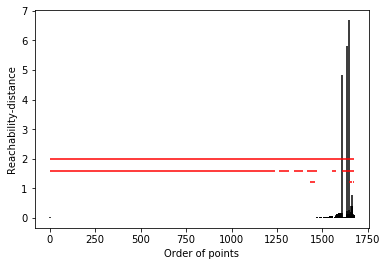

In [36]:
H = HierarchicalClustering(sp)

## Graph Building 하기

## Test

In [37]:
print("Level1 Cluster:" ,H)

if len(H.children)<1:
    print("Level2 Cluster 없음")
else:
    for h in H.children:
        print("Level2 Cluster:", h)
        
for h in H.children:
    if len(h.children)<1:
        print("Level3 Cluster 없음")
    else:
        for h_c in h.children:
            print("Level3 Cluster:", h_c)

Level1 Cluster: <__main__.TreeNode object at 0x00000202920B6208>
Level2 Cluster: <__main__.TreeNode object at 0x00000202A07FC278>
Level2 Cluster: <__main__.TreeNode object at 0x00000202A07FC208>
Level2 Cluster: <__main__.TreeNode object at 0x00000202A07FC160>
Level2 Cluster: <__main__.TreeNode object at 0x00000202A07F9FD0>
Level2 Cluster: <__main__.TreeNode object at 0x00000202A07F9E80>
Level2 Cluster: <__main__.TreeNode object at 0x00000202A07F9940>
Level2 Cluster: <__main__.TreeNode object at 0x00000202A07F9668>
Level2 Cluster: <__main__.TreeNode object at 0x00000202A07F95C0>
Level2 Cluster: <__main__.TreeNode object at 0x00000202A07F9550>
Level3 Cluster 없음
Level3 Cluster 없음
Level3 Cluster 없음
Level3 Cluster 없음
Level3 Cluster: <__main__.TreeNode object at 0x00000202A07FC390>
Level3 Cluster 없음
Level3 Cluster 없음
Level3 Cluster 없음
Level3 Cluster: <__main__.TreeNode object at 0x00000202A07FC198>
Level3 Cluster: <__main__.TreeNode object at 0x00000202A07FC240>


## Hierarchy graph 를 Array형태로 변환하는 함수 (level을 얻기 쉬움)

In [38]:
def getArray(node, num, arr):
    if node is not None:
        if len(arr) <= num:
            arr.append([])
        try:
            arr[num].append(node)
        except:
            arr[num] = []
            arr[num].append(node)
        for n in node.children:
            getArray(n, num + 1, arr)
        return arr
    else:
        return arr
    

## TBHG 구하기

In [39]:
H_array = getArray(H, 0,[0]) #모든 Cluster들을 레벨 별로 배열에 넣기
GraphList = [] # 모든 레벨의 그래프들
usercountCtoCAllList = []

# print(len(os.listdir(dir))) #User 수 
# print(a) # LocationHistory 리스트  

for level in range(1,len(H_array)): # 각 레벨을 반복하면서 (최상위 레벨의 그래프는 접근하지 않는다.간선을 이을필요가없으므로)
    #Graph = [] # 한개 래벨의 그래프 배열에 만들어서 넣어야하나
    #Graph.append(H_array[level])# 각 레벨에 있는 cluster node들을 Graph에 넣고
    #print(Graph)
    usercountCtoCList = [] #
    pgraph = perLevelGraph() # 각 그래프 객체에 cluster, edge를 넣어야하나.
    pgraph.cluster = H_array[level]
#     print(pgraph.cluster)
#     print(pgraph.edge)
    for uid in range(len(os.listdir(dir))): #각 그래프를 유저의수만큼 반복하면서
#         print(uid) # 각 유저의 번호
#         print(uid,"번째의 location history:", a[uid].locationhistory) #각 유저의 LocH
        print(uid , "유저의 location history 정보")
        g ,usercountCtoC =GraphBuilding(pgraph, a[uid], len(os.listdir(dir)), uid) #** 여기서 각 유저의 그래프에 대한 간선이 모두 들어간 그래프와 클러스터i->클러스터j를 어떤 유저가 갔는지에 대한 배열이 나와야한다
        print(uid , "유저의 location history 정보를 가지고 그래프에 간선 추가 연결 success!")
#         print(g.edge)
#         print(usercountCtoC)
        usercountCtoCList.append(usercountCtoC)
    GraphList.append(g) #  한레벨의 graph의 모든 유저의 연속된 staypoint객체 간선의 정보를 가진 그래프를 추가.
#     print(GraphList)
    usercountCtoCAllList.append(usercountCtoCList)
# print(usercountCtoCAllList) #모든 유저들의 Ci -> Cj 카운트 
TBHG = (H,GraphList)
#print(TBHG)
# 그 다음 매트릭스를 만들기 위한 각 유저들이 클러스터를 몇번 방문했는지 정보는 아직 .. 어디서 구하지?

0 유저의 location history 정보
0 유저의 location history 정보를 가지고 그래프에 간선 추가 연결 success!
1 유저의 location history 정보
1 유저의 location history 정보를 가지고 그래프에 간선 추가 연결 success!
2 유저의 location history 정보
2 유저의 location history 정보를 가지고 그래프에 간선 추가 연결 success!
3 유저의 location history 정보
3 유저의 location history 정보를 가지고 그래프에 간선 추가 연결 success!
4 유저의 location history 정보
4 유저의 location history 정보를 가지고 그래프에 간선 추가 연결 success!
0 유저의 location history 정보
0 유저의 location history 정보를 가지고 그래프에 간선 추가 연결 success!
1 유저의 location history 정보
1 유저의 location history 정보를 가지고 그래프에 간선 추가 연결 success!
2 유저의 location history 정보
2 유저의 location history 정보를 가지고 그래프에 간선 추가 연결 success!
3 유저의 location history 정보
3 유저의 location history 정보를 가지고 그래프에 간선 추가 연결 success!
4 유저의 location history 정보
4 유저의 location history 정보를 가지고 그래프에 간선 추가 연결 success!


## Location Interest Inference 하기

i:  0 j: 0


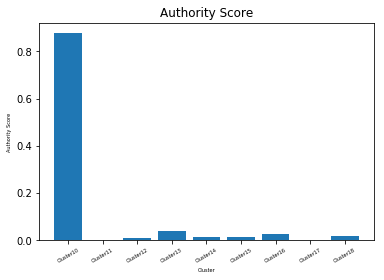

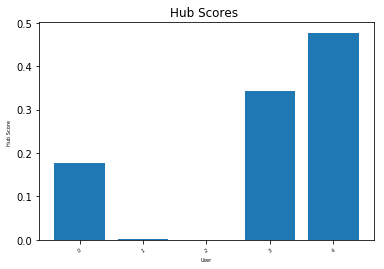

C:\Users\IBK\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


0 - 0 level 기준  1  단계level의 구역에서의 가장 경험많은 유저는 User 4 이며 hub점수는 0.4773360929366469  이고,가장 흥미로운 지역은 Cluster 10 이며, authority 점수는 0.8761881608100907  이고, 추천경로는 Cluster 13 에서 Cluster 10  입니다.
i:  0 j: 0


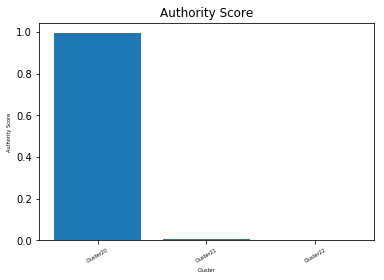

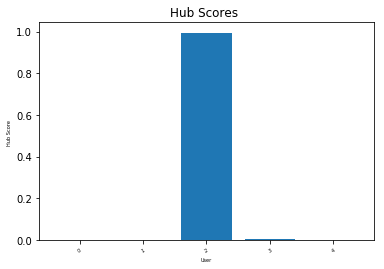

0 - 0 level 기준  2  단계level의 구역에서의 가장 경험많은 유저는 User 2 이며 hub점수는 0.9947009623791612  이고,가장 흥미로운 지역은 Cluster 20 이며, authority 점수는 0.9933369235420405  이고, 추천경로는 없습니다.
i:  1 j: 4


C:\Users\IBK\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


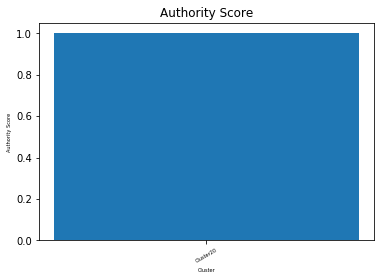

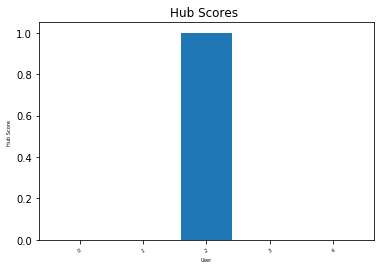

1 - 4 level 기준  2  단계level의 구역에서의 가장 경험많은 유저는 User 2 이며 hub점수는 1.0  이고,가장 흥미로운 지역은 Cluster 20 이며, authority 점수는 1.0  이고, 추천경로는 없습니다.
i:  1 j: 8


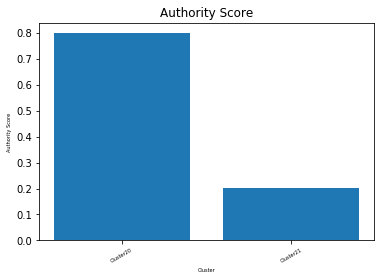

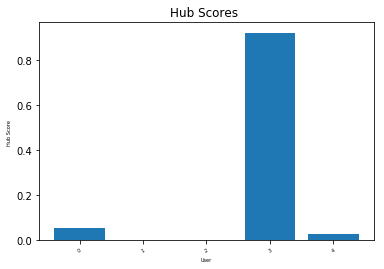

1 - 8 level 기준  2  단계level의 구역에서의 가장 경험많은 유저는 User 3 이며 hub점수는 0.9226089996461037  이고,가장 흥미로운 지역은 Cluster 20 이며, authority 점수는 0.7988866656303463  이고, 추천경로는 없습니다.


In [56]:
hubList = []
authList = []

#len(H_array[1])

for level in range(0,len(H_array)-1):  #각 level을 반복하면서
#     print("Level: " , level)
    for cnum in range(0,len(H_array[level])): # for each cluster on this level
#         print(H_array[level][cnum]) # 각 레벨의 각 클러스터 
        for dlevel in range(level+1, len(H_array)):
#             print("i: ", level, "j:", cnum) # 해당구역 레벨을 포함하는 전체 덩어리
#             print("x", dlevel) #해당 구역 레벨
            C = LocationCollecting(dlevel, H_array[level][cnum], H_array) # # cij에 대해서 x 레벨에 있는 자식 노드들을 정하는 것
#             print(C) #하위 자식노드가 없으면 HITS 추론 하지말아야함 
            if len(C)>0:
                print("i: ", level, "j:", cnum)
#                 print("x", dlevel)
                M=MatrixBuilding(C, a) #각 레벨의 클러스터들과 유저들의 Loch를 비교하면서, Matrix 생성
    #             print(M)
                auth,hub = HITSInference(M,dlevel)
                #최고 hub 유저, auth 지역 찾기
                maxhubscore = -1
                maxauthscore = -1
                maxhubindex = 0
                maxauthindex = 0 
                for i in range(len(auth)):
                    if auth[i] > maxauthscore:
                        maxauthscore=auth[i]
                        maxauthindex=i
                for i in range(len(hub)):
                    if hub[i] > maxhubscore:
                        maxhubscore=hub[i]
                        maxhubindex=i        
    #             print(auth,hub)
                #여기에서 추천경로 구하기
                if len(C)>0:
                    bestscore, ci, cj = MiningTravelSequences(TBHG,C,auth,hub,dlevel,usercountCtoCAllList)#
                    if ci==0 and cj==0:
                        print(level,"-",cnum,"level 기준 ",dlevel," 단계level의 구역에서의 가장 경험많은 유저는 User",maxhubindex,"이며 hub점수는",maxhubscore," 이고,가장 흥미로운 지역은 Cluster",str(dlevel)+str(maxauthindex), "이며, authority 점수는", maxauthscore," 이고, 추천경로는 없습니다.")
                    else:
                        print(level,"-",cnum,"level 기준 ",dlevel," 단계level의 구역에서의 가장 경험많은 유저는 User",maxhubindex,"이며 hub점수는",maxhubscore," 이고,가장 흥미로운 지역은 Cluster",str(dlevel)+str(maxauthindex), "이며, authority 점수는", maxauthscore," 이고, 추천경로는 Cluster",str(dlevel)+str(ci),"에서 Cluster",str(dlevel)+str(cj)," 입니다.")
                       
                authList.append(auth)
                hubList.append(hub)
                
            #여기에서 해당 location의 추천 경로를 찾아야한다.
            
# print(authList) #모든 user에 대한 모든 지역의 auth점수들
# print(hubList) #모든 유저들의 지역에 대한 hub점수

# Mining Classical Travel Sequences 하기

In [41]:
#간선 정보  
print(TBHG[1][0].edge)

{<__main__.TreeNode object at 0x00000202A07FC160>: [<__main__.TreeNode object at 0x00000202A07FC278>, <__main__.TreeNode object at 0x00000202A07FC278>, <__main__.TreeNode object at 0x00000202A07FC208>, <__main__.TreeNode object at 0x00000202A07FC208>, <__main__.TreeNode object at 0x00000202A07FC208>, <__main__.TreeNode object at 0x00000202A07FC208>, <__main__.TreeNode object at 0x00000202A07F9E80>, <__main__.TreeNode object at 0x00000202A07FC208>, <__main__.TreeNode object at 0x00000202A07FC208>, <__main__.TreeNode object at 0x00000202A07F95C0>, <__main__.TreeNode object at 0x00000202A07F9E80>, <__main__.TreeNode object at 0x00000202A07FC278>, <__main__.TreeNode object at 0x00000202A07FC278>, <__main__.TreeNode object at 0x00000202A07FC278>, <__main__.TreeNode object at 0x00000202A07FC278>, <__main__.TreeNode object at 0x00000202A07FC278>, <__main__.TreeNode object at 0x00000202A07FC278>, <__main__.TreeNode object at 0x00000202A07FC278>, <__main__.TreeNode object at 0x00000202A07FC278>

## TEST ===============================================================

## LocationCollecting Test (상대적인 하위레벨 노드 반환하기)

In [42]:
#LocationCollecting Test
class Tree(object):
    def __init__(self):
        self.data = None
        self.child = []
    
root = Tree()
root.data="C00"

C11=Tree()
C11.data="C11"

C12=Tree()
C12.data="C12"

C21=Tree()
C21.data="C21"
C22=Tree()
C22.data="C22"
C23=Tree()
C23.data="C23"
C24=Tree()
C24.data="C24"
C25=Tree()
C25.data="C25"
C31=Tree()
C31.data="C31"
C32=Tree()
C32.data="C32"
C33=Tree()
C33.data="C33"
C34=Tree()
C34.data="C34"


root.child=[C11,C12]
C11.child=[C21,C22]
C12.child=[C23,C24,C25]
C21.child=[C31]
C22.child=[C32,C33]
C24.child=[C34]
array =[[root],[C11,C12],[C21,C22,C23,C24,C25],[C31,C32,C33,C34]]



def findchildnode(x,cij, H):
    childList = []
    #cij의 level 찾기
    for level in range(0,len(H)):
        #print(level)
        if cij in H[level]:
#             print(level ,"여기있어")
            count= x-level # 해당노드에서 특정 레벨까지의 degree
            break
#     print("count 값:", count)
    
    
#     for childnode in cij.child:
#             print("지금 자식 노드:", childnode)
#             if count> 0:
#                 findchildnode(x,childnode, H)
#     count-=1            
    
#     childList.append(childnode)
    
    
        #print("f") #몇번 반복하는 지 알수 있어
        #여기에서 자식노드를 찾아
        
        #print(cij.child)
    count-=1

    if count>0: #더 순회해야할할 하위 레벨이 있으면 
        for childnode in cij.child: #그 레벨의 자식노드들의 각각을 반복하며
            childnodeList= findchildnode(x,childnode,H) #하위 레벨의 자식노드들을 반환하고
            for cn in childnodeList: #childList 배열에 넣어준다.
                childList.append(cn) 
            
    if count== 0: #더 순회해야할 레벨이 없으면
        for childnode in cij.child: #바로 childList 배열에 넣어준다.
            childList.append(childnode)
    
    
    #print(childList)
        
        
    return childList


for level in range(0, len(array)-1):
#     print("Level: " , level)
    for cnum in range(0,len(array[level])): # for each cluster on this level
#        0 print(array[level][cnum]) # 각 레벨의 각 클러스터 
        for dlevel in range(level+1, len(array)):
            print("i: ", level, "j:", cnum)
            print("x", dlevel)
            C = findchildnode(dlevel, array[level][cnum], array) 
            print(C)
  

i:  0 j: 0
x 1
[<__main__.Tree object at 0x000002029DB8B208>, <__main__.Tree object at 0x000002029DB8B320>]
i:  0 j: 0
x 2
[<__main__.Tree object at 0x000002029DB8B358>, <__main__.Tree object at 0x000002029DB8B390>, <__main__.Tree object at 0x000002029DB8B3C8>, <__main__.Tree object at 0x000002029DB8B400>, <__main__.Tree object at 0x000002029DB8B438>]
i:  0 j: 0
x 3
[<__main__.Tree object at 0x000002029DB8B470>, <__main__.Tree object at 0x000002029DB8B4A8>, <__main__.Tree object at 0x000002029DB8B4E0>, <__main__.Tree object at 0x000002029DB8B518>]
i:  1 j: 0
x 2
[<__main__.Tree object at 0x000002029DB8B358>, <__main__.Tree object at 0x000002029DB8B390>]
i:  1 j: 0
x 3
[<__main__.Tree object at 0x000002029DB8B470>, <__main__.Tree object at 0x000002029DB8B4A8>, <__main__.Tree object at 0x000002029DB8B4E0>]
i:  1 j: 1
x 2
[<__main__.Tree object at 0x000002029DB8B3C8>, <__main__.Tree object at 0x000002029DB8B400>, <__main__.Tree object at 0x000002029DB8B438>]
i:  1 j: 1
x 3
i:  2 j: 0
x 3


## HITS Test 

[[  0 193  13   6   3   4]
 [ 20   2   1  25   0   0]
 [  0   0   0   2  41  10]]
3
6
[0.00136967 0.8774731  0.05916366 0.02903155 0.01455505 0.01840696]
[0.98040366 0.01476993 0.00482641]
['Cluster10', 'Cluster11', 'Cluster12', 'Cluster13', 'Cluster14', 'Cluster15']
[0 1 2]


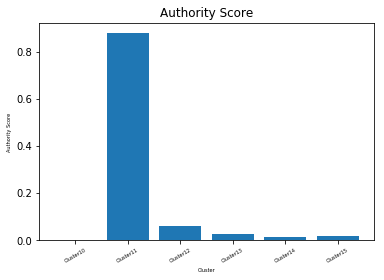

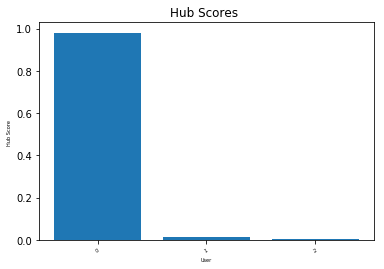

In [43]:
def hits(A,dlevel):
    print(A) #Matrix 정보
    hubnum= A.shape[0]
    print(hubnum) #유저 수
    authnum=A.shape[1]
    print(authnum) #지역 수
    a = np.ones(authnum)
    h = np.ones(hubnum)
#     print(a)
#     print(h)
#     print(n)
    Au= np.dot(np.transpose(A),A)
#     print(Au)
    Hu = np.dot(A,np.transpose(A))
#     print(Hu)
#     print(a.T,h.T)
    for j in range(5):
        a = np.dot(Au,a.T)
        a= a/sum(a)
        h = np.dot(Hu,h)
        h = h/ sum(h)
    print(a) #authority점수
    print(h) #hub점수
    
    alabel =[]
    for i in range(0,authnum):
        alabel.append("Cluster"+str(dlevel)+str(i))  #authority score x축 CLuster 지역 Label 만들기
    print(alabel)
    hlabel = np.arange(hubnum)  #hub score x축 User id Label 만들기
    print(hlabel)
    aindex = np.arange(len(alabel))
    hindex = np.arange(len(hlabel))
    plt.bar(aindex, a)
    plt.xlabel('Cluster', fontsize=5)
    plt.ylabel('Authority Score', fontsize=5)
    plt.xticks(aindex, alabel, fontsize=5, rotation=30)
    plt.title('Authority Score')
    plt.show()
    
    
    plt.bar(hindex, h)
    plt.xlabel('User', fontsize=5)
    plt.ylabel('Hub Score ', fontsize=5)
    plt.xticks(hindex, hlabel, fontsize=5, rotation=30)
    plt.title('Hub Scores ')
    plt.show()
    
    
M=[[0,193,13,6,3,4],[20,2,1,25,0,0],[0,0,0,2,41,10]]    
M = np.array(M)

hits(M,1)

## Connect Node,Count using dict Test

In [44]:
# class perLevelGraph(object): 
#     def __init__(self): # 
#         self.cluster = 0
#         self.edge = {
#                      } #간선의 구조를 해당노드:[연결된 노드,카운트]
        
#     # 간선을 이어주는 함수( 현재노드, 이어질 노드)
    
#     count =1
#     def addEdge(self,node,neighbour):
#         if node not in self.edge:
#             self.edge[node]=[neighbour]
# #             self.edge[node]['connectcount']=1
           
#         else:
# #             self.edge[node]['connectcount']+=1
#             if neighbour not in self.edge[node]: #이미 안에 중복인 연결이 있으면 하지 않기 . 클러스터->클러스터 count를 해야하면, 여기서 하기
                
#                 self.edge[node].append(neighbour)
                

edge = {"1번노드":["2번","3번","4번","4번","4번"]}

list(set(edge["1번노드"]))
count=0
for value in edge["1번노드"]:
    if value=="4번":
        count+=1
        
count #다넣고 그냥, 이걸로가자
    


# print(edge["1번노드"])
# print(edge["1번노드"][0]) #iteration돌아야하겠찌.
# print(edge["1번노드"][0]["연결노드"]) #추가해줘야함
# print(edge["1번노드"][0]["연결횟수"]+1) #++1

# print(edge["2번노드"])

# print(edge
    


3

In [45]:
usercountCtoC= np.zeros((3,6,6))
usercountCtoC

array([[[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]])